In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

# Functions we'll use

def fetch_image_data(image_path: str, 
                     show_image: bool = True) -> np.ndarray:
    """
    Reads an image file from the given path using Pillow, and returns it as a NumPy array.
    Optionally, displays the image using Matplotlib.

    Args:
        image_path (str): Path to the image file.
        show_image (bool): Whether to display the image using Matplotlib. Default is True.

    Returns:
        np.ndarray: A NumPy array representing the image.

    Raises:
        FileNotFoundError: If the specified image file does not exist.
        ValueError: If the specified image file is not a valid image file or could not be read.

    """

    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"{image_path} not found")
    try:
        with Image.open(image_path) as image:
            example_image = plt.imread(image_path)
            if show_image:
                plt.figure()
                plt.imshow(example_image)
                plt.title('Image display of: ' + image_path)
            return example_image
    except Exception as e:
        raise ValueError(f"Could not read {image_path}: {str(e)}")


Text(0, 0.5, 'Raw image values')

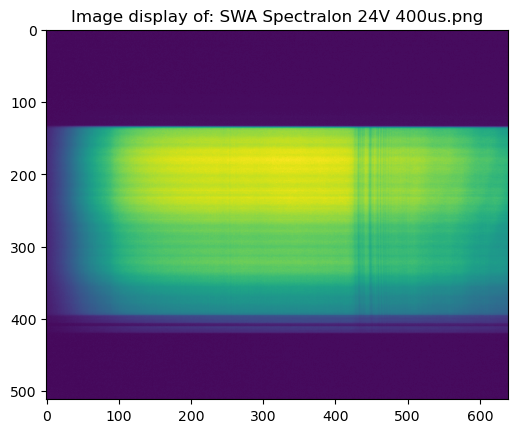

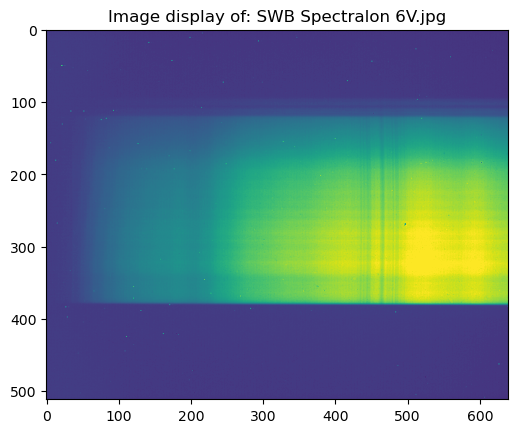

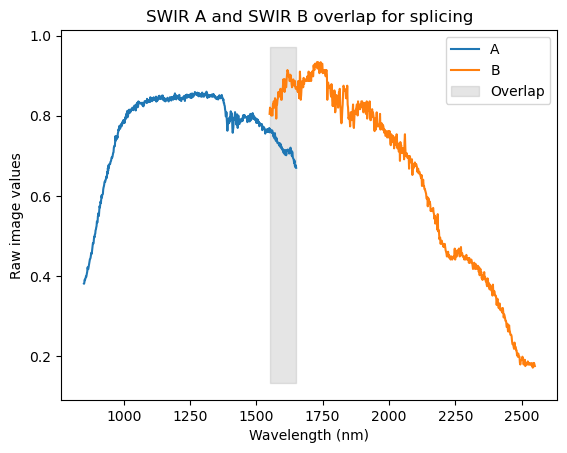

In [3]:
swir_A = fetch_image_data('SWA Spectralon 24V 400us.png')
swir_B = fetch_image_data('SWB Spectralon 6V.jpg')

pixel_to_select = 250

# Info from Mike
# SWIR A (850 to 1650nm) and SWIR B (1550 to 2550nm)
# SWIR A is 850nm on the Left and 1650 on the right
# SWIR B is 2550 on the left and 1550nm on the right. 

wavelengths_A = np.linspace(850, 1650, swir_A.shape[1])
wavelengths_B = np.linspace(1550, 2550, swir_B.shape[1])

pixel_A = swir_A[pixel_to_select, :]
# B data is scaled to 256, A is scaled between 0 and 1, fix this
pixel_B = np.flip(swir_B[pixel_to_select, :] / 256)

# Plot the current data and where they overlap
plt.figure()
plt.plot(wavelengths_A, pixel_A)
plt.plot(wavelengths_B, pixel_B)

# Find the overlap region
overlap_start = max(min(wavelengths_A), min(wavelengths_B))
overlap_end = min(max(wavelengths_A), max(wavelengths_B))

# Add a shaded region to show the overlap
plt.fill_between([overlap_start, overlap_end], plt.ylim()[0], plt.ylim()[1], color='gray', alpha=0.2)

# Add a legend to the plot
plt.legend(['A', 'B', 'Overlap'])
plt.title('SWIR A and SWIR B overlap for splicing')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Raw image values')

Lambda prime  = overlap region between the two spectra
lambda double prime = non overlaping region

we assume that neither of the overlapping sets is a reliable estimate of the final spectrum. For this reason, we decide that a possible correct position could be the mean between V′ and S′, noticing that this observation can be adjusted based on specific priors:


Overlap start: 1550.0
Overlap end:   1650.0
V' size': (80,)
S' size': (64,)


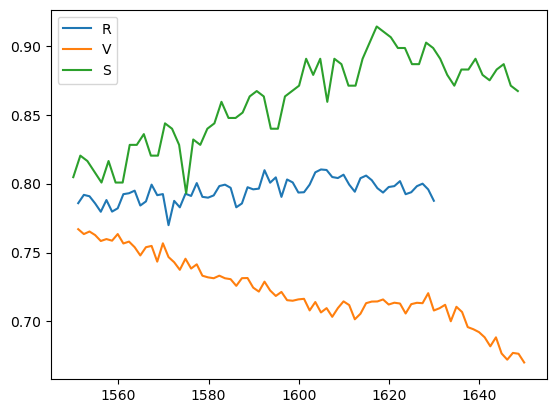

In [35]:
print(f"Overlap start: {overlap_start}")
print(f"Overlap end:   {overlap_end}")

# Let's identify V and S primes, i.e. the overlapping data region

v_prime = pixel_A[wavelengths_A >= overlap_start]
s_prime = pixel_B[wavelengths_B <= overlap_end]

print(f"V' size': {v_prime.shape}")
print(f"S' size': {s_prime.shape}")


R = 0.5 * (v_prime[0:len(s_prime)] + s_prime)
R_wavelengths = wavelengths_A[wavelengths_A >= overlap_start][0:len(s_prime)]

plt.plot(R_wavelengths, R)
plt.plot(wavelengths_A[wavelengths_A >= overlap_start], v_prime)
plt.plot(wavelengths_B[wavelengths_B <= overlap_end], s_prime)
plt.legend(['R', 'V', 'S'])

phi'v and phi's are the correcting coefficients to scale V' and S'. We want them to smoothly vary from phi'v of 0 to a phi's of 1, and we'll get there with a logistic function. 

Logistic function defined as:
```
L: maximum value
k: slope
x0: center of distribution
```

L is either the unity value or the coefficient at the extreme of the overlapping range: φv ∈ Φ′v (first coefficient) and φs ∈ Φ′s (last coefficient),

k and x0 are determined as a function of the distance ∆r between V′ and S′:

∆r = sqrt(1/N' * sum(V' - S')**2

N' is the number of bands in the overlapping range

The center of the logistic curve x0 is intrinsically linked to the width of the spectral window that will experience the correction, as it is the median value of the selected interval. Therefore, λ0 is obtained indirectly from the modeling of the window width w.

The Window width w is modeled:
```
wv = N''v / (1 + exp(-cv(∆r-x0v)
ws = V''s / (1 + exp(-cs(∆r-x0s)
```
N'' and V'' are the number of bands Lambda''v and Lambda''s

Parameters cv, cs, x0v, and x0s are learned by fitting the logistic function to the logarithmically spaced values of ∆r

In [51]:
# determine the new length
new_length = max(len(v_prime), len(s_prime))

# interpolate v_prime to the new length
v_resampled = np.interp(np.linspace(0, len(v_prime) - 1, new_length),
                        np.arange(len(v_prime)), v_prime)

# interpolate s_prime to the new length
s_resampled = np.interp(np.linspace(0, len(s_prime) - 1, new_length),
                        np.arange(len(s_prime)), s_prime)


dr = np.sqrt((1/v_resampled.shape[0]) * np.sum((v_resampled - s_resampled)**2))

# wv = wavelengths_A.shape[0] / (1 + exp(-cv(∆r-x0v)


Text(0.5, 1.0, 'Visualize what is going on with deltaR')

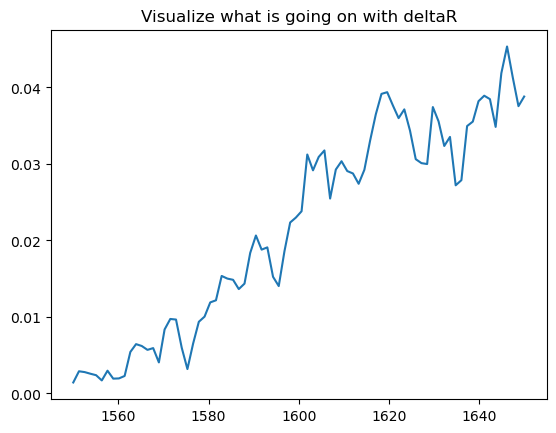

In [57]:
plt.plot(np.linspace(overlap_start, overlap_end, v_resampled.shape[0]), 
         (v_resampled-s_resampled)**2)
plt.title('Visualize what is going on with deltaR')

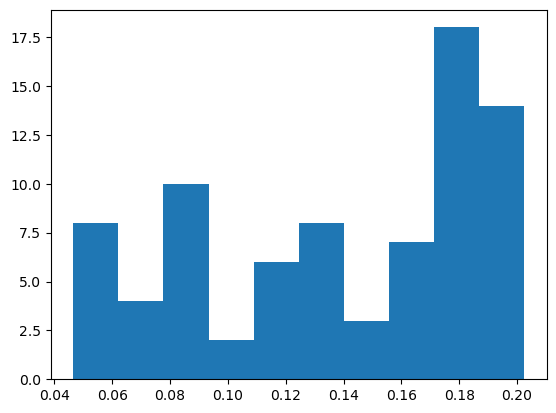

Signature:
plt.hist(
    x,
    bins=None,
    range=None,
    density=False,
    weights=None,
    cumulative=False,
    bottom=None,
    histtype='bar',
    align='mid',
    orientation='vertical',
    rwidth=None,
    log=False,
    color=None,
    label=None,
    stacked=False,
    *,
    data=None,
    **kwargs,
)
Docstring:
Compute and plot a histogram.

This method uses `numpy.histogram` to bin the data in *x* and count the
number of values in each bin, then draws the distribution either as a
`.BarContainer` or `.Polygon`. The *bins*, *range*, *density*, and
*weights* parameters are forwarded to `numpy.histogram`.

If the data has already been binned and counted, use `~.bar` or
`~.stairs` to plot the distribution::

    counts, bins = np.histogram(x)
    plt.stairs(counts, bins)

Alternatively, plot pre-computed bins and counts using ``hist()`` by
treating each bin as a single point with a weight equal to its count::

    plt.hist(bins[:-1], bins, weights=counts)

The data input

In [78]:
# Do I need to generate a distribution of dR's using a loop and growing the size of the window, 
#or maybe just use a moving window to generate a distribution?

dr_list = []
w_size = 5
for i in range(len(v_resampled-w_size)):
# i = 0
    dr_list.append(np.sqrt((1/w_size) * np.sum((v_resampled[i:i+w_size] - s_resampled[i:i+w_size])**2)))

plt.hist(dr_list)
plt.hist?

In [79]:
import numpy as np
from scipy.optimize import curve_fit

def kv(delta_r, a, b, y):
    return a * np.exp(b * delta_r) + y

# Create a linear vector decreasing from 1 to 0
delta_r = np.linspace(0, 1, num=100)

# Generate noisy data
data = kv(delta_r, 2, -1, 0.5) + np.random.normal(scale=0.1, size=100)

# Fit the kv function to the data
params, _ = curve_fit(kv, delta_r, data)

# Print the fitted parameters
print("a =", params[0])
print("b =", params[1])
print("y =", params[2])


a = 1.8863185359517227
b = -1.1946105423705458
y = 0.6604030921679309


In [84]:
import numpy as np
from scipy.optimize import curve_fit

def logistic_function(x, c, x0, N):
    return N / (1 + np.exp(-c * (x - x0)))

def wv(delta_r, N_v, c_v, x0_v):
    return logistic_function(delta_r, c_v, x0_v, N_v)

def ws(delta_r, N_s, c_s, x0_s):
    return logistic_function(delta_r, c_s, x0_s, N_s)

# Generate example data
v_resampled = np.random.normal(0, 1, size=(100, 10))
s_resampled = np.random.normal(0, 1, size=(100, 10))
delta_r = np.sqrt((1/v_resampled.shape[0]) * np.sum((v_resampled - s_resampled)**2))

# Generate logarithmically spaced values of delta_r
log_delta_r = np.logspace(np.log10(delta_r.min()), np.log10(delta_r.max()), num=100)

# Calculate wv and ws values for each delta_r value
N_v = 10
c_v = 2
x0_v = 0.5
N_s = 8
c_s = 1.5
x0_s = 0.3
wv_values = wv(log_delta_r, N_v, c_v, x0_v)
ws_values = ws(log_delta_r, N_s, c_s, x0_s)

# Fit the logistic function to the data
p0 = [1, np.median(log_delta_r), np.mean(wv_values)]
params_v, _ = curve_fit(logistic_function, log_delta_r, wv_values, p0=p0)
p0 = [1, np.median(log_delta_r), np.mean(ws_values)]
params_s, _ = curve_fit(logistic_function, log_delta_r, ws_values, p0=p0)

# Print the fitted parameters
print("cv =", params_v[0])
print("x0v =", params_v[1])
print("Nv =", params_v[2])
print("cs =", params_s[0])
print("x0s =", params_s[1])
print("Ns =", params_s[2])



cv = 1.017413785085379
x0v = 4.724132221488881
Nv = 23.656034590324712
cs = 0.9069555451680447
x0s = 3.6584141034613844
Ns = 11.99497585457342


array([[-1.84067997e+00,  7.36637713e-02, -4.45332002e-01,
         1.64653878e+00, -6.26588833e-01,  7.79004071e-01,
        -4.18573946e-01, -8.31809121e-01,  8.98295589e-01,
        -6.14558109e-01],
       [ 6.56500643e-01, -1.00322235e+00,  1.72280241e+00,
        -5.50227138e-01,  4.97771286e-01,  9.30075432e-01,
         9.26704124e-01,  1.19855697e-01, -4.93189759e-02,
         5.08984202e-01],
       [-3.74422513e-02,  3.92618590e-02, -2.02236407e-01,
         8.19209061e-01,  1.51995211e-01, -9.42171145e-01,
         3.33742455e-01, -8.27421338e-01,  3.04798950e-01,
         4.36269660e-01],
       [-2.65507810e-01,  1.05929171e-01, -1.82660693e-01,
         3.51881644e-01,  5.89852795e-01, -3.39050872e-01,
         5.75463619e-02,  8.02245333e-01,  2.36025559e-01,
        -1.78709110e+00],
       [-1.47635115e+00,  9.51441149e-01,  4.56630316e-02,
        -3.91137241e-01,  7.14128189e-01, -1.84547839e-01,
        -2.36419989e-02,  6.50942797e-01,  5.16833621e-01,
         9.